### Наши задачи:

1. Выявить нехарактерное для данного потребителя потребление в определенный день. 

Если поступающие за день данные нейросеть сочтет нехарактерными для сложившегося у данного потребителя паттерна потребления (возможные причины - техническая неисправность счетчика, сбой передачи данных, воровство), то она должна сигнализировать об этом. 

2. Предсказать будущее значение потребления по конкретному потребителю.

In [ ]:
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt

import os

In [ ]:
os.chdir('/content/drive/MyDrive/_Проекты/Personal_projects/Layout detection')

### Готовим данные

In [ ]:
from IPython.display import clear_output

In [ ]:
# скачали и посмотрели на выборку
df = pd.read_csv('data_for_nn.csv', sep="\t", index_col='Unnamed: 0')
#df.rename(columns = {'vals_0': 'Group'}, inplace=True)
print(df.shape)
df

(91, 971)


,905020000001,905020000020,905020000106,905020000108,905020000201,905020000210,905020000274,905020000286,905020000295,905020000303,905020000350,905020000246,905020000404,905020000408,905020000451,905020000454,905020000474,905020000484,905020000509,905020000513,905020000524,905020000528,905020000540,905020000561,905020000574,905020000581,905020000599,905020000602,905020000610,905020000611,905020000645,905020000730,905020000763,905020000770,905020000830,905020000874,905020000887,905020000934,905020000942,905020000963,...,905020008590,905020008601,905020008607,905020008608,905020008609,905020008615,905020008639,905020008642,905020008643,905020008646,905020008658,905020008659,905020008660,905020008669,905020008678,905020008689,905020008698,905020008699,905020008731,905020008781,905020008784,905020008786,905020008814,905020008906,905020008912,905020008922,905020008924,905020008928,905020008931,905020008943,905020008944,905020008949,905020008954,905020008960,905020008961,905020008964,905020008967,905020008971,905020008978,905020008996
0,0.049675,0.103572,0.249345,0.054180,0.104902,0.221153,0.088127,0.082862,0.038165,0.042115,0.021897,NaN,0.0,NaN,0.036809,0.005410,0.035646,0.060007,0.050210,0.037335,0.050147,0.052641,0.050393,0.032135,0.020799,0.028322,0.069465,0.088424,0.104986,0.079277,0.083764,0.032860,0.107994,0.097233,0.052766,0.063826,0.224688,0.061656,0.161341,0.362718,...,0.028261,0.013741,NaN,0.033974,0.020723,2.726917,2.838771,0.0,0.020241,0.222236,0.040267,0.089205,0.034514,0.022038,0.027180,0.021946,0.0,1.194295,0.023737,0.620968,0.173594,19.744322,0.106454,-0.012802,0.312077,0.106216,0.701945,0.213842,0.060861,0.079923,0.018985,0.001901,4.861616,0.395753,0.270656,7.75,0.142261,0.188588,0.119102,0.464686
1,0.022449,0.118402,0.200000,0.001587,0.104902,0.000000,0.723077,0.024446,0.288722,0.097136,0.109589,NaN,0.0,NaN,0.285714,0.012500,0.014925,0.510496,0.719168,0.228600,0.020888,0.577434,0.544444,0.168478,0.109936,0.137026,1.636816,0.051630,0.058934,0.000000,0.020952,0.117960,1.403448,1.732394,0.190527,0.569767,0.210438,2.637479,0.042316,0.030519,...,0.092466,0.023162,NaN,0.260417,0.053266,0.031133,0.049498,0.0,0.013228,0.095907,0.186620,0.022829,0.126449,0.120666,0.069844,0.111111,0.0,0.000000,0.017898,30.666667,0.500000,0.000000,0.833333,0.153846,0.125535,5.171233,0.594059,0.075188,0.131313,0.175705,0.005254,0.000000,0.000000,2.882353,0.000000,7.75,0.823529,0.333333,1.300000,0.126761
2,0.075256,0.300652,4.000000,0.000792,0.104902,0.000000,0.276786,0.016209,0.200700,0.162231,0.059699,NaN,0.0,NaN,0.506173,0.000000,0.000000,0.308907,0.159032,0.144180,0.022379,0.319776,0.191847,0.062791,0.053728,0.077564,0.739623,0.064887,0.027827,-0.996795,0.029565,0.135932,0.591105,0.747423,0.413201,0.688889,0.105702,0.084761,0.076313,0.052930,...,0.103448,0.017717,NaN,0.295455,0.049618,0.027069,0.028999,0.0,0.040826,0.050008,0.344214,0.014071,0.110384,0.113299,0.056836,0.137500,0.0,65.000000,0.035388,0.684211,0.050000,116.222222,1.424242,0.000000,0.096536,0.000000,0.372671,0.034965,0.486607,0.193727,0.005710,0.000000,61.666667,1.954545,0.000000,7.75,0.126728,0.625000,0.086957,0.043750
3,0.015583,0.082598,0.933333,0.000792,1.787860,0.000000,0.545455,0.013292,0.306122,0.136063,0.038142,NaN,0.0,NaN,0.090164,0.000000,-0.960784,0.309846,0.119314,0.285111,0.040025,0.174283,0.140845,0.048140,0.043895,0.173111,0.298265,0.042599,0.027938,0.778626,0.025845,0.129707,0.256988,0.162242,0.178503,0.182018,0.021069,-0.934419,0.026659,0.033513,...,0.092803,0.021857,NaN,0.188198,0.032727,0.028383,0.029731,0.0,0.028506,0.031545,0.114790,0.016268,0.265375,0.071093,0.037791,0.065934,0.0,0.075758,0.016552,0.406250,0.047619,0.473934,0.212500,0.200000,0.046234,0.214206,0.312217,0.695946,0.048048,0.122102,0.004523,0.000000,0.521277,3.051282,1.666667,7.75,0.000000,0.000000,0.032800,0.017964
4,0.023810,0.179444,0.000000,0.000791,2.819262,10.641256,0.266968,0.044600,0.093750,0.167829,0.046580,NaN,0.0,NaN,0.195489,0.002806,0.000000,0.177598,0.070620,0.157217,0.041341,

## Обучение Нейросети
в будущем для каждого потребителя будут храниться индивидуальные модели, которые будут загружаться при необходимости

Договоримся о том, что считать отклонениями

![autoencoder-architecture.png](pictures/autoencoder-architecture.png)


### Импорт и функции:
* get_consumer
* Autoencoder
* model_fit
* get_mistakes


In [ ]:
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, LSTM, RepeatVector
from tensorflow.keras.layers import Activation, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop, Adamax
from IPython.display import clear_output

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [ ]:
RANDOM_SEED = 42 # задаем случайное значение

In [ ]:
def get_consumer(dailyChange, number):
  consumer = dailyChange[firmNames[number]]
  #group9['class'] = 0 # добавили столбец для расчета выбросов
  consumer.plot(figsize=(14, 2)) #строим график чтобы визуально оценить выбросы

  #берем характеристики группы и сравниваем их 
  consumer_stat = consumer.describe()
  consumer_norma = consumer_stat['mean'] + 2*consumer_stat['std']
  consumer_norma_max = consumer_stat['mean'] + 2*consumer_stat['std']
  consumer_norma_min = consumer_stat['mean'] - 2*consumer_stat['std']
  #print('\nConsumer name = ', firmNames[number])
  print('consumer_mean = ', round(consumer_stat['mean'], 3),
        '\tconsumer_2std = ', round(2*consumer_stat['std'], 3),
        '\tconsumer_norma ', round(consumer_norma_min, 3), '==>', round(consumer_norma_max, 3))

  
  # Выделим отклонения
  frauds = consumer[(consumer < consumer_norma_min) | (consumer > consumer_norma_max)]
  # Выделим норму
  normal = consumer[(consumer >= consumer_norma_min) & (consumer <= consumer_norma_max)]

  #print('frauds cases = ', len(frauds), '\tnormal cases = ', len(normal))

  # Нормализуем данные
  normal = MinMaxScaler().fit_transform(normal.values.reshape(-1, 1))
  frauds = MinMaxScaler().fit_transform(frauds.values.reshape(-1, 1))

  # берём нормализованные данные и разбиваем на train_test(только 'X')
  X_train, X_test = train_test_split(normal, test_size=0.2, random_state=RANDOM_SEED)
  #print('X_train = ', X_train.shape, '\tX_test = ', X_test.shape, '\tfrauds = ', frauds.shape)

  return X_train, X_test, normal, frauds

![Autoencoder](https://lilianweng.github.io/lil-log/assets/images/autoencoder-architecture.png)
*Sample Autoencoder Architecture [Image Source](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html)*

In [ ]:
def Autoencoder(X_train): # объявляем автокодировщик для определения мошенич.транзакций
  dataInput = Input(shape=(X_train.shape[1], )) # задаем эти размеры как входные в сеть
  
  x = Dense(100, activation='linear')(dataInput) # пропускаем через полносвязный слой размером 10
  x = Dense(X_train.shape[1], activation='linear')(x) # и через полносвязный слой размером X_train.shape[1]
  
  autoencoder = Model(inputs = dataInput, outputs=x) # собрали модель 
  autoencoder.compile(optimizer = Adam(learning_rate = 1e-03), loss='mse') # компилируем модель также, с выбором оптимайзера и среднеквадратичной ошибки
  
  return autoencoder 

In [ ]:
def model_fit(X_train, firmNames, number):
  os.chdir('/content/drive/MyDrive/_Проекты/Personal_projects/Layout detection/outputs')
  model = Autoencoder(X_train)

  # коллбэки
  early_stopping = EarlyStopping(monitor = 'loss',patience = 8, verbose = 0,
                                 restore_best_weights = True)
  reduce_lr = ReduceLROnPlateau(monitor = 'loss', factor = 0.9, patience = 2, 
                                min_lr = 1e-07, verbose = 0)
  checkpoint = ModelCheckpoint('consumer_%d.h5' % (int(firmNames[number])), monitor='loss',
                               verbose = 0, save_best_only=True, save_weights_only = True)
  

  history = model.fit(X_train, X_train, epochs = 100, verbose = 0,
                      callbacks = [early_stopping, reduce_lr, checkpoint],
                      batch_size=1) # загружаем данные в модель(X_train'ы) и обучаем)

  #clear_output()

  title = 'Consume #%d' % (int(firmNames[number]))
  plt.figure()
  plt.plot(history.history['loss'])
  plt.title(title)
  plt.grid()
  plt.show()

In [ ]:
def get_mistakes(X_test, frauds, firmNames, number):
  os.chdir('/content/drive/MyDrive/_Проекты/Personal_projects/Layout detection/outputs')
  model = Autoencoder(X_train)
  model.load_weights('consumer_%d.h5' % (int(firmNames[number])))

  predictions_normal = model.predict(X_test) # делаем предсказание по X_test
  predictions_frauds = model.predict(frauds) # делаем предсказание frauds

  # определяем среднеквадратичную ошибку по X_test и предсказания frauds
  mse_normal = np.mean(np.power(X_test - predictions_normal, 2), axis=1)
  mse_frauds = np.mean(np.power(frauds - predictions_frauds, 2), axis=1)
  print("MIN и MAX ERR определения нормы:", round(min(mse_normal),4), '\t===>', round(max(mse_normal),4))
  #print("Medium err определения нормы:", round(sum(mse_normal) / len(mse_normal),4))
  print("MIN и MAX ERR определения аномалии:", round(min(mse_frauds),4), '\t===>', round(max(mse_frauds),4))
  #print("Medium err определения аномалии:", round(sum(mse_frauds) / len(mse_frauds),4))

### Подготовка данных

In [ ]:
dailyChange = df # посчитали изменение дневного потребления (которые будем анализировать)
#dailyChange.replace([np.inf, -np.inf], np.nan, inplace=True) # замена inf на NaN
# используем метод .transform(), чтобы заполнить значения NaN групповым средним
#dailyChange = dailyChange.transform(lambda x: x.fillna(x.mean()))
#dailyChange.fillna(0, inplace=True) # Заменили NA значения на 0

#print(dailyChange.shape)
dailyChange[-3:]

,905020000001,905020000020,905020000106,905020000108,905020000201,905020000210,905020000274,905020000286,905020000295,905020000303,905020000350,905020000246,905020000404,905020000408,905020000451,905020000454,905020000474,905020000484,905020000509,905020000513,905020000524,905020000528,905020000540,905020000561,905020000574,905020000581,905020000599,905020000602,905020000610,905020000611,905020000645,905020000730,905020000763,905020000770,905020000830,905020000874,905020000887,905020000934,905020000942,905020000963,...,905020008590,905020008601,905020008607,905020008608,905020008609,905020008615,905020008639,905020008642,905020008643,905020008646,905020008658,905020008659,905020008660,905020008669,905020008678,905020008689,905020008698,905020008699,905020008731,905020008781,905020008784,905020008786,905020008814,905020008906,905020008912,905020008922,905020008924,905020008928,905020008931,905020008943,905020008944,905020008949,905020008954,905020008960,905020008961,905020008964,905020008967,905020008971,905020008978,905020008996
88,0.011749,0.071364,0.249345,0.05418,0.104902,0.221153,0.088127,0.015199,0.014105,0.042115,0.114179,NaN,0.0,NaN,0.032012,0.00541,0.035646,0.060007,0.005041,0.037335,0.050147,0.052641,0.018366,0.005353,0.020799,0.008488,0.011544,0.057215,0.019545,0.079277,0.038793,0.091321,0.107994,0.029127,0.052766,0.014583,0.224688,0.005557,0.035393,0.039714,...,0.011867,0.010011,NaN,0.007674,0.020723,0.040142,0.040346,0.0,0.008619,0.222236,0.011488,0.052299,0.034514,0.005420,0.02718,0.021946,0.0,1.194295,0.023737,0.620968,0.173594,19.744322,0.106454,-0.012802,0.312077,0.106216,0.701945,0.213842,0.060861,0.079923,0.018985,0.001901,4.861616,0.395753,0.270656,7.75,0.142261,0.188588,0.119102,0.464686
89,0.027702,0.021479,0.249345,0.05418,0.104902,0.221153,0.088127,0.015268,0.017262,0.042115,0.010993,NaN,0.0,NaN,0.005170,0.00541,0.035646,0.060007,0.014167,0.037335,0.050147,0.052641,0.019077,0.004294,0.020799,0.002911,0.011763,0.050537,0.027178,0.079277,0.054633,0.054402,0.107994,0.015789,0.052766,0.007187,0.224688,0.006715,0.042262,0.051972,...,0.009676,0.007329,NaN,0.006898,0.020723,0.072645,0.041274,0.0,0.010753,0.222236,0.014196,0.040027,0.034514,0.004667,0.02718,0.021946,0.0,1.194295,0.023737,0.620968,0.173594,19.744322,0.106454,-0.012802,0.312077,0.106216,0.701945,0.213842,0.060861,0.079923,0.018985,0.001901,4.861616,0.395753,0.270656,7.75,0.142261,0.188588,0.119102,0.464686
90,0.034846,0.016657,0.249345,0.05418,0.104902,0.221153,0.088127,0.012557,0.056949,0.042115,0.091530,NaN,0.0,NaN,0.004409,0.00541,0.035646,0.060007,0.022782,0.037335,0.050147,0.052641,0.009967,0.005986,0.020799,0.015586,0.011857,0.055303,0.025041,0.079277,0.130055,0.057213,0.107994,0.024189,0.052766,0.004179,0.224688,0.016409,0.044425,0.016667,...,0.009486,0.007275,NaN,0.010275,0.020723,0.064550,0.043895,0.0,0.009425,0.222236,0.009854,0.032072,0.034514,0.003795,0.02718,0.021946,0.0,1.194295,0.023737,0.620968,0.173594,19.744322,0.106454,-0.012802,0.312077,0.106216,0.701945,0.213842,0.060861,0.079923,0.018985,0.001901,4.861616,0.395753,0.270656,7.75,0.142261,0.188588,0.119102,0.464686


In [ ]:
firmNames = list(dailyChange) # Получаем имена столбцов (потребителей)
int(firmNames[0])

905020000001

## Выявление аномалий с помощью НС - Энкодера

### Обучение энкодера


 ------------------------------ 
 905020001746
consumer_mean =  0.043 	consumer_2std =  0.161 	consumer_norma  -0.118 ==> 0.205
frauds cases =  3 	normal cases =  88
X_train =  (70, 1) 	X_test =  (18, 1) 	frauds =  (3, 1)


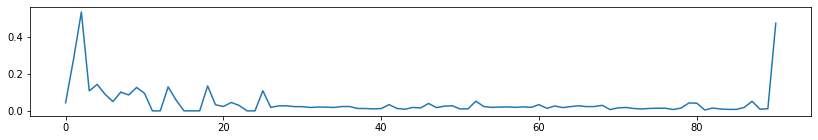

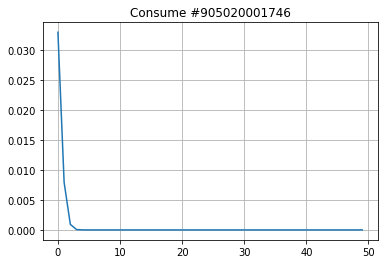

MIN и MAX ERR определения нормы: 0.0 	===> 0.0
MIN и MAX ERR определения аномалии: 0.0 	===> 0.0


In [ ]:
#for i in firmNames:
for i in [100]:
  print('\n', '-'*30, '\n', firmNames[i])

  X_train, X_test, normal, frauds = get_consumer(dailyChange, i)
  print('frauds cases = ', len(frauds), '\tnormal cases = ', len(normal))
  print('X_train = ', X_train.shape, '\tX_test = ', X_test.shape, '\tfrauds = ', frauds.shape)

  Autoencoder(X_train)
  model_fit(X_train, firmNames, i)
  get_mistakes(X_test, frauds, firmNames, i)

### Проверяем выбранного потребителя

------------------------------ 
Для Consume # 905020001746 :
 ------------------------------ 



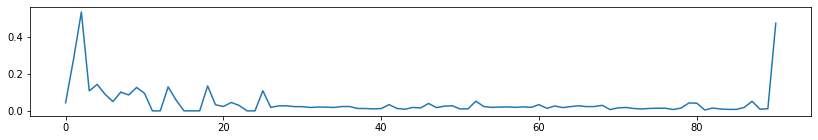

In [ ]:
number = 100 # выбрали порядковый номер потребителя
consumer = dailyChange[firmNames[number]]
idx = consumer.index.tolist() # получаем список индексов
print('-'*30, '\nДля Consume #', firmNames[number], ':\n', '-'*30, '\n')
consumer.plot(figsize=(14, 2)) #строим график чтобы визуально оценить выбросы

In [ ]:
consumer_stat = consumer.describe()
consumer_norma_min = consumer_stat['mean'] - 2*consumer_stat['std']
consumer_norma_max = consumer_stat['mean'] + 2*consumer_stat['std']
print("MIN и MAX определения нормы:", round(consumer_norma_min,4), '===>', round(consumer_norma_max,4))
normal = consumer[consumer <= consumer_norma_max] # Выделим норму меньше max
normal = normal[normal >= consumer_norma_min] # Выделим норму меньше max
print('Всего нормальных измерений:', normal.shape[0])

xScaler = MinMaxScaler()
xScaler.fit(normal.values.reshape(-1, 1))
consumer_normal_scal = xScaler.transform(normal.values.reshape(-1, 1))
consumer_scal = xScaler.transform(consumer.values.reshape(-1, 1))

#consumer_normal_scal = MinMaxScaler().fit_transform(normal.values.reshape(-1, 1)) # Нормализуем данные normal
model = Autoencoder(consumer_scal)
predictions_normal = model.predict(consumer_scal) # делаем предсказание по normal

# определяем среднеквадратичную ошибку по normal
consumer_norma_max = np.mean(predictions_normal) + 2*np.std(predictions_normal)
consumer_norma_min = np.mean(predictions_normal) - 2*np.std(predictions_normal)

# Определения нормы для скалированных данных
print("MIN и MAX определения нормы для нормализованных данных:", round(consumer_norma_min,4), '===>', round(consumer_norma_max,4))

MIN и MAX определения нормы: -0.1178 ===> 0.2047
Всего нормальных измерений: 88
MIN и MAX определения нормы для нормализованных данных: -0.0693 ===> 0.1209


In [ ]:
# idx взят из математической проверки 
predictions = model.predict(consumer_scal)

n = 0
print('-'*30, '\nДни аномального потребления Consume #', firmNames[number], ':\n', '-'*30, '\n')
for i in range(len(consumer)):   # Выбираю пример
  if predictions[i] < consumer_norma_min or predictions[i] > consumer_norma_max:
    n += 1
    print(n, idx[i], '\tПотребление:', round(consumer[i], 4), '\t Отклонение')
  

------------------------------ 
Дни аномального потребления Consume # 905020001746 :
 ------------------------------ 

1 1 	Потребление: 0.2764 	 Отклонение
2 2 	Потребление: 0.5332 	 Отклонение
3 90 	Потребление: 0.4727 	 Отклонение
